In [2]:
import glob
import os
import torch
import numpy as np
import xarray as xr
import netCDF4 as nc
import pandas as pd
import simpy as sp
import logging
import multiprocessing as mp
from multiprocessing import Pool
from typing import Any, Iterable
from datetime import datetime as dt, timedelta as td

In [3]:
import cdsapi

In [4]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [5]:
os.chdir('..')

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
from datasets.retrieval import grab_df_from_era5_csvs
from datasets.km_dataset import DeepKoopmanDataset
from models.km_classical import ClassicalKoopmanAnalysis
from models.km_havoc import HAVOCAnalysis
from models.km_net import DeepKoopmanWrapper

In [8]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [9]:
import matplotlib.pyplot as plt

# EDA Koopman Forecast of Maritime Weather

## ERA5 Around Hamburg Harbor

ERA5 is a dataset which provides hourly maritime weather data.<br>
Its API does only provide single point measurements, but we can play a little and grab this data for multiple points all together.

![Map with coordinated of HH harbor with midpoint of the grid.](../img/map_grid_hhh.png)<br>
*Coastal map. The blue point is at coordinates lon 10 and lat 53.5, around Hamburg Harbor.*<br>
*The red dot is representing the initial radius taken when data mining the region of interest.*<br>
*One can see that that the mean on that point needs to be far more at the caostal line to get sufficiant forecasting!*

![Map with the grid of sampled datapoints.](../img/map_grid_hhh_2.png)<br>
*Coastal map with maritime weather datapoint (ERA5) for coastal line related to HH Habor.* <br>
*The blue points are complete and red ones have missing data. Only the blue ones will be considered.*<br>

In [10]:
# params
data_path = './data'
center_lon, center_lat = 5.5, 56.5
radius = 4.5
step = 0.5
start_date = '2025-02-01'
end_date = '2025-09-30'

output_dir = os.path.join(data_path, f"{start_date}--{end_date}")
lon_vals = np.arange(center_lon - radius, center_lon + radius + step, step)
lat_vals = np.arange(center_lat - radius, center_lat + radius + step, step)

In [11]:
df = grab_df_from_era5_csvs(output_dir, lat_vals, lon_vals)
df

,time,u100,v100,u10,v10,d2m,t2m,msl,sst,skt,sp,ssrd,strd,tp,lat,lon,mwd,mwp,swh
0,2025-02-01 00:00:00,-1.227249,4.551605,-0.971558,2.206314,276.52350,277.55730,103012.190,NaN,275.89688,102521.016,0.0,987721.60,0.000000e+00,52.0,1.0,NaN,NaN,NaN
1,2025-02-01 01:00:00,-1.344467,4.589905,-1.027405,2.290192,276.49360,277.50160,103025.500,NaN,275.48804,102534.330,0.0,1026047.44,0.000000e+00,52.0,1.0,NaN,NaN,NaN
2,2025-02-01 02:00:00,-1.250153,4.995331,-0.835266,2.517288,276.37183,277.37183,103046.810,NaN,275.55533,102554.920,0.0,1021265.70,0.000000e+00,52.0,1.0,NaN,NaN,NaN
3,2025-02-01 03:00:00,-1.073959,5.168274,-0.689453,2.575562,275.93164,276.87340,103048.560,NaN,275.18945,102556.310,0.0,958170.00,4.768372e-07,52.0,1.0,NaN,NaN,NaN
4,2025-02-01 04:00:00,-0.700256,5.065414,-0.453903,2.541901,275.88983,276.80780,103031.750,NaN,275.37950,102539.140,0.0,979850.20,0.000000e+00,52.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096683,2025-09-30 19:00:00,-1.078003,3.887268,-0.837814,1.905701,277.56770,278.32910,103420.125,NaN,278.16960,95322.080,0.0,1168652.20,3.099441e-05,61.0,10.0,NaN,NaN,NaN
2096684,2025-09-30 20:00:00,-0.953369,3.793167,-0.762024,1.887436,277.37200,277.93220,103431.625,NaN,278.13623,95328.805,0.0,1155937.60,2.861023e-05,61.0,10.0,NaN,NaN,NaN
2096685,2025-09-30 21:00:00,-0.952301,3.694656,-0.779129,1.820908,277.21252,277.76376,103446.375,NaN,277.84314,95336.560,0.0,1173570.80,3.004074e-05,61.0,10.0,NaN,NaN,NaN
2096686,2025-09-30 22:00:00,-0.584839,2.949158,-0.589203,1.509872,277.02023,277.70374,103458.060,NaN,277.23773,95322.200,0.0,1146051.50,3.337860e-05,61.0,10.0,NaN,NaN,NaN


In [12]:
df = df.dropna(subset=[
    'sp',
    'ssrd',
    'strd',
    'tp',
    'mwd',
    'mwp',
    'swh'
])

In [13]:
df.shape

(1422960, 19)

In [17]:
# prefilter lat, lon and time
lat_max, lat_min = df['lat'].max(), df['lat'].min()
lon_max, lon_min = df['lon'].max(), df['lon'].min()
df['time'] = pd.to_datetime(df['time'])
time_max, time_min = df['time'].max(), df['time'].min()
dates = pd.Series(pd.date_range(time_min, time_max, 1)).dt.date.values

filt_lat = np.arange(lat_min, lat_max, step)[::3]
filt_lon = np.arange(lat_min, lat_max, step)[::3]

filt_time = df['time'][df['time'] > (time_max - td(days=24))]
sprt_time = dates[::24]

C:\Users\szaif\AppData\Local\Temp\ipykernel_76216\2368134841.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])


## Temporal Decompositions

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
from skopt import gp_minimize
from skopt.space import Integer
from skopt.plots import plot_convergence

In [19]:
variables = [
    "t2m",  # "2m_temperature",
    "msl",  # "mean_sea_level_pressure",
    "skt",  # "skin_temperature",
    "sp",   # "surface_pressure",
    "ssrd", # "surface_solar_radiation_downwards",
    "tp",   # "total_precipitation"
]

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(74)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(311)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(91)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(483)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evalua

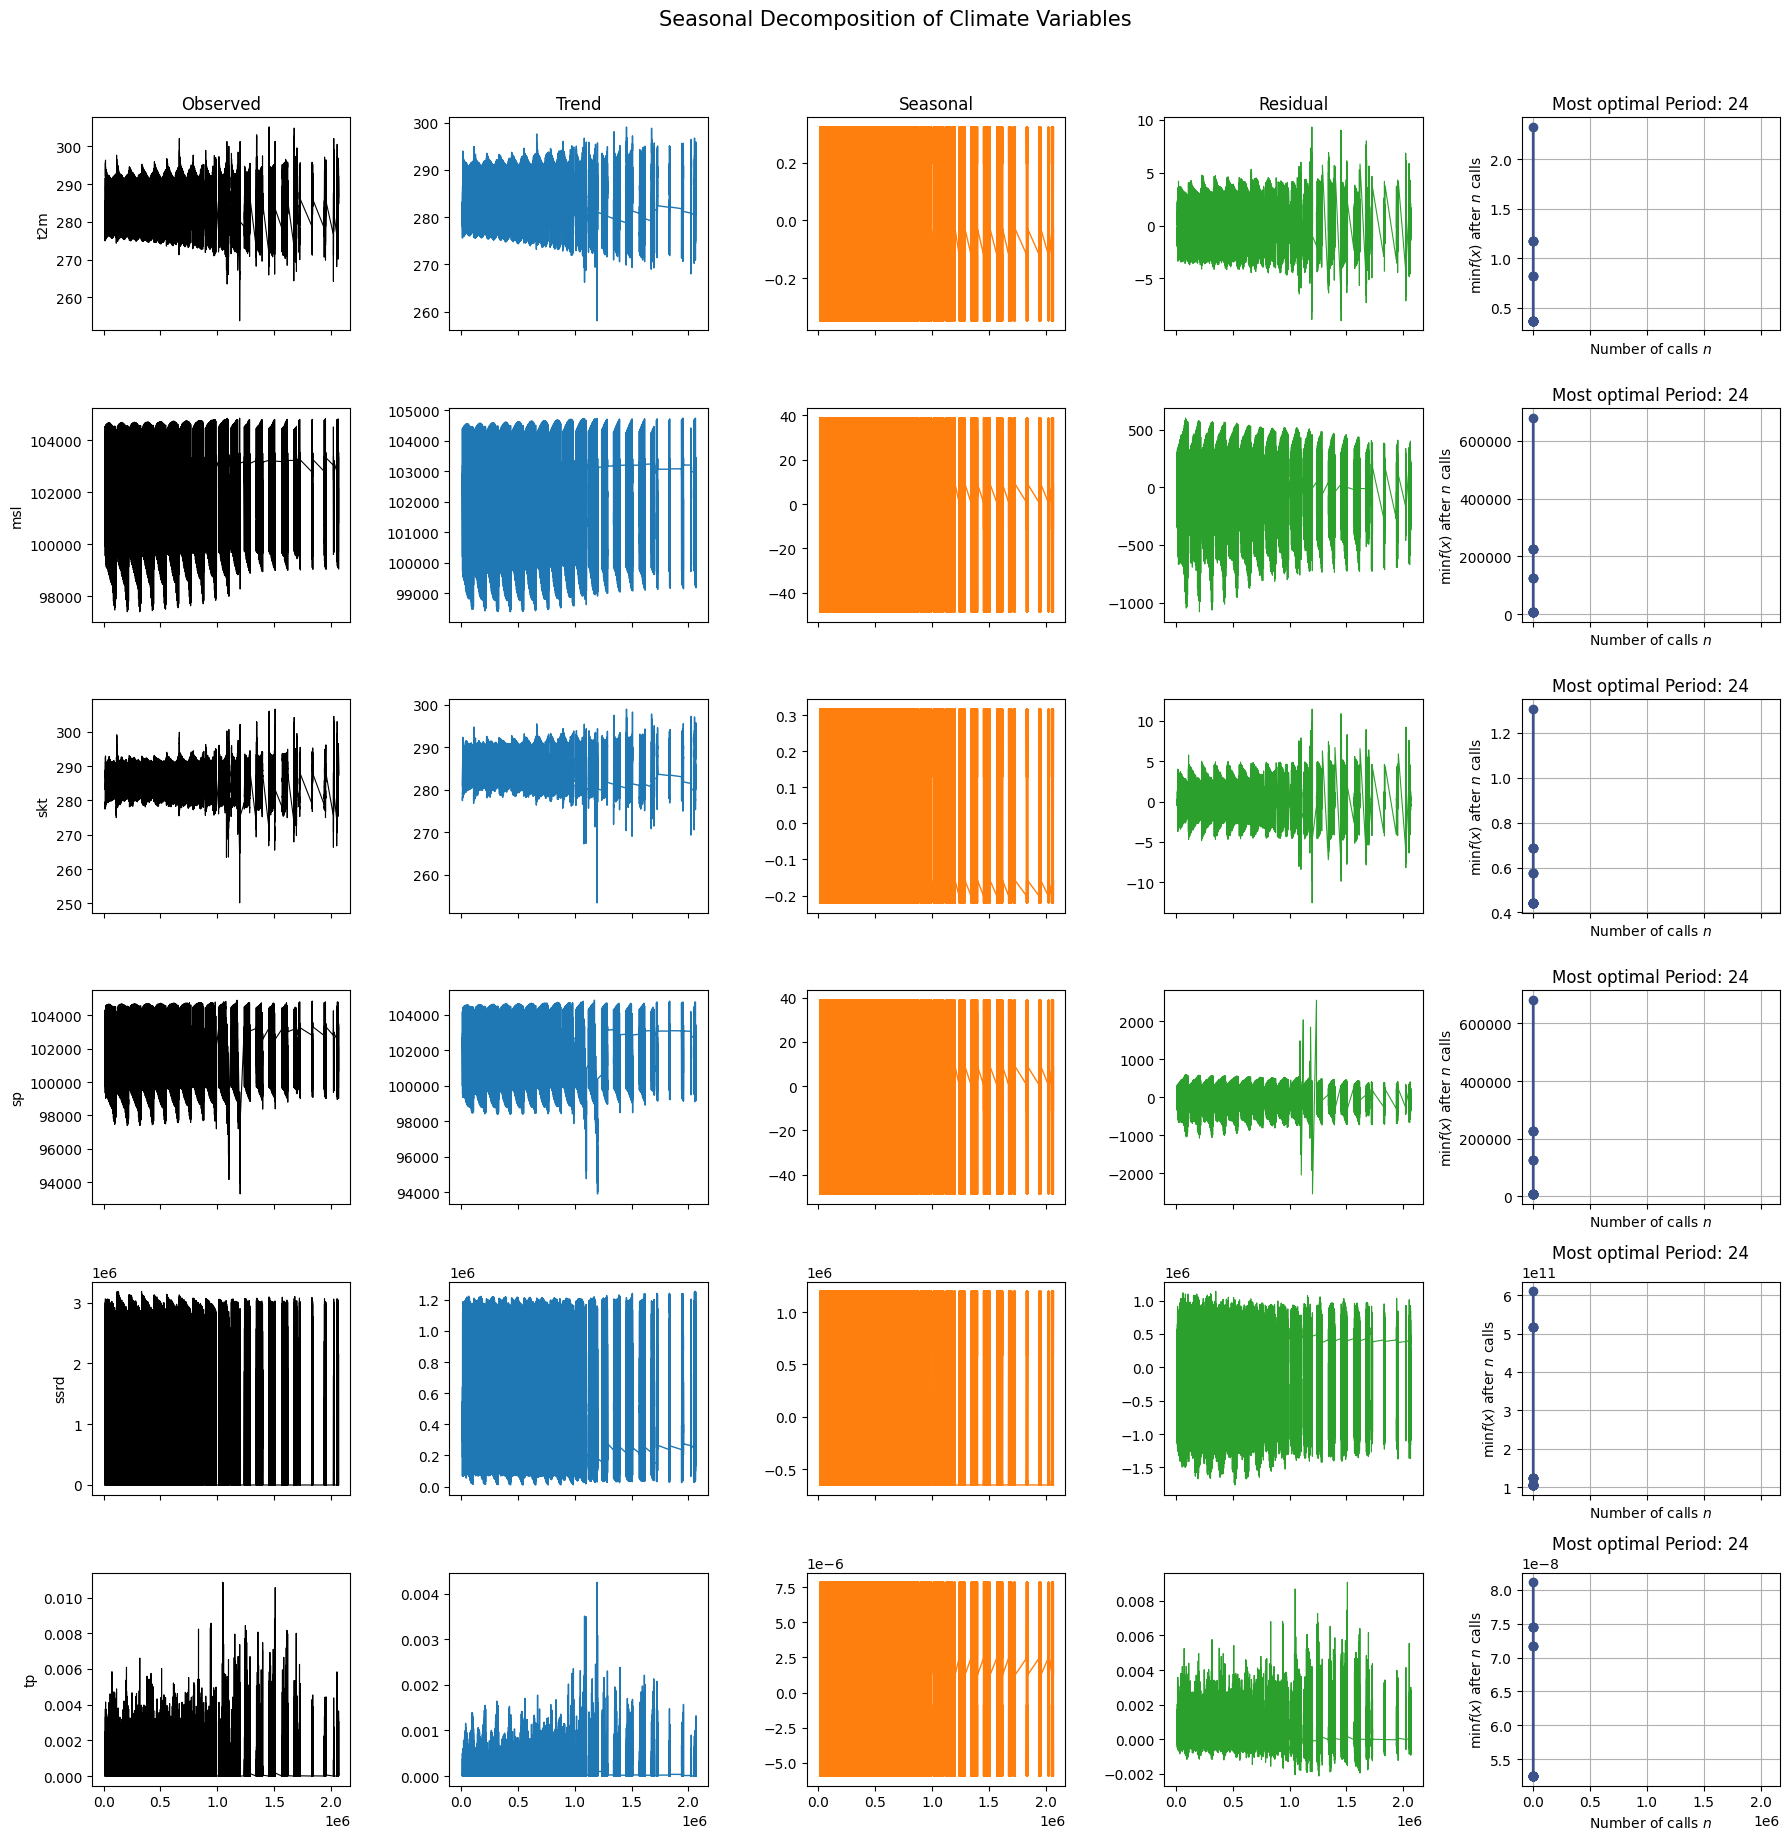

In [ ]:
# Prepare a grid of subplots (rows per variable)
n_vars = len(variables)
# Define search space — e.g., range of candidate periods (hourly → 6h to 120 days)
periods = [Integer(3, 18, name="period")]

# main plot frame
fig, axes = plt.subplots(
    nrows=n_vars, ncols=5, figsize=(18, 3 * n_vars), sharex=True
)
column_titles = ["Observed", "Trend", "Seasonal", "Residual", "Period Convergence"]
for j, title in enumerate(column_titles):
    axes[0, j].set_title(title, fontsize=12)

# Loop and plot results for each variable
for i, var in enumerate(variables):
    series = df[var].dropna()

    # Define objective function to minimize residual error
    def objective(period) -> (Any | float):
        period = 8*period[0]
        try:
            result = seasonal_decompose(series, model="additive", period=int(period))
            resid = result.resid.dropna()
            # compute sum of squared residual
            score = np.mean(resid.values ** 2)
        except Exception:
            score = np.inf  # invalid period or failed decomposition
        return score

    # Run Bayesian optimization
    res = gp_minimize(
        objective,
        dimensions=periods,
        n_calls=25,
        n_random_starts=8,
        random_state=42,
    )

    # parse "optimal" period
    period = res.x[0]
    
    # get final decomposition
    result = seasonal_decompose(series, model="additive", period=period)

    axes[i, 0].plot(result.observed, color="black", lw=0.8)
    axes[i, 0].set_ylabel(var)
    axes[i, 1].plot(result.trend, color="tab:blue", lw=1.0)
    axes[i, 2].plot(result.seasonal, color="tab:orange", lw=1.0)
    axes[i, 3].plot(result.resid, color="tab:green", lw=0.8)
    plot_convergence(res, ax=axes[i, 4])
    axes[i, 4].set_title(f"Most optimal Period: {period}")

plt.suptitle("Seasonal Decomposition of Climate Variables", fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

### Windowed Decompositions

In [29]:
from utils.tsa_features import wavelet_feature_variables

In [33]:
df_wav = wavelet_feature_variables(df, variables, window=48, step=12)

: 

: 